# ÂÆâË£ù SHAP Â•ó‰ª∂

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


# ÂÆâË£ù‰∏Ä‰∫õÂøÖË¶ÅÂ•ó‰ª∂

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Step 1ÔºöË≥áÊñôÁêÜËß£ËàáÊé¢Á¥¢ÊÄßÂàÜÊûêÔºàEDAÔºâ

Ê¨Ñ‰ΩçÂêçÁ®±	 Ë™™Êòé

|----------|--------------|

datetime	ÊôÇÈñìÊà≥ÔºàÊØèÂ∞èÊôÇÔºâ

season	Â≠£ÁØÄÔºà1:Êò•, 2:Â§è, 3:Áßã, 4:ÂÜ¨Ôºâ

holiday	ÊòØÂê¶ÁÇ∫ÂÅáÊó•Ôºà0/1Ôºâ

workingday	ÊòØÂê¶ÁÇ∫Â∑•‰ΩúÊó•ÔºàÈÄ±Êú´ËàáÂÅáÊó•ÁÇ∫0Ôºâ

weather	Â§©Ê∞£ÁãÄÊ≥ÅÔºà1-4ÔºåÊï∏Â≠óË∂äÂ§ßÂ§©Ê∞£Ë∂äÂ∑ÆÔºâ

temp	ÊîùÊ∞èÊ∫´Â∫¶ÔºàÂØ¶ÈöõÊ∫´Â∫¶Ôºâ

atemp	È´îÊÑüÊ∫´Â∫¶

humidity	ÊøïÂ∫¶Ôºà%Ôºâ

windspeed	È¢®ÈÄü

casual	ÈùûË®ªÂÜä‰ΩøÁî®ËÄÖÁßüÂÄüÊï∏

registered	Ë®ªÂÜä‰ΩøÁî®ËÄÖÁßüÂÄüÊï∏

count	Á∏ΩÁßüÂÄüÊï∏Ôºàcasual + registeredÔºâ

In [2]:
df = pd.read_csv("train.csv", parse_dates=["dteday"])
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     15919 non-null  int64         
 1   dteday      15919 non-null  datetime64[ns]
 2   season      15919 non-null  int64         
 3   yr          15919 non-null  int64         
 4   mnth        15919 non-null  int64         
 5   hr          15919 non-null  int64         
 6   holiday     15919 non-null  int64         
 7   weekday     15919 non-null  int64         
 8   workingday  15919 non-null  int64         
 9   weathersit  15919 non-null  int64         
 10  temp        15919 non-null  float64       
 11  atemp       15919 non-null  float64       
 12  hum         15919 non-null  float64       
 13  windspeed   15919 non-null  float64       
 14  cnt         15919 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(10)
memory usage: 1.8 MB
None


ÊØèÊó•Á∏ΩÁßüÂÄüÊï∏ÊôÇÈñìÂ∫èÂàó

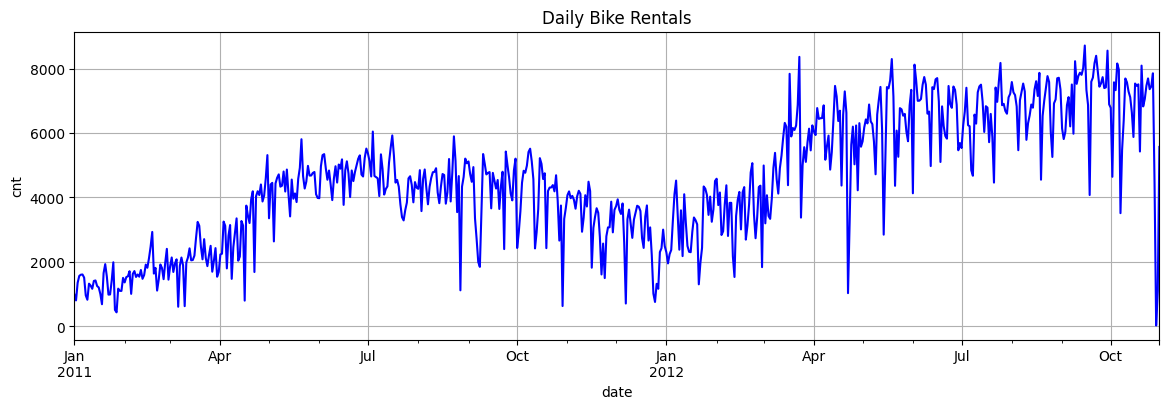

In [3]:
df["date"] = df["dteday"]
daily = df.groupby("date")["cnt"].sum()

plt.figure(figsize=(14, 4))
daily.plot(title="Daily Bike Rentals", color="blue", label="cnt")
plt.ylabel("cnt")
plt.grid(True)
plt.show()

ÊØèÊó•Á∏ΩÁßüÂÄüÈáèË∂®Âã¢

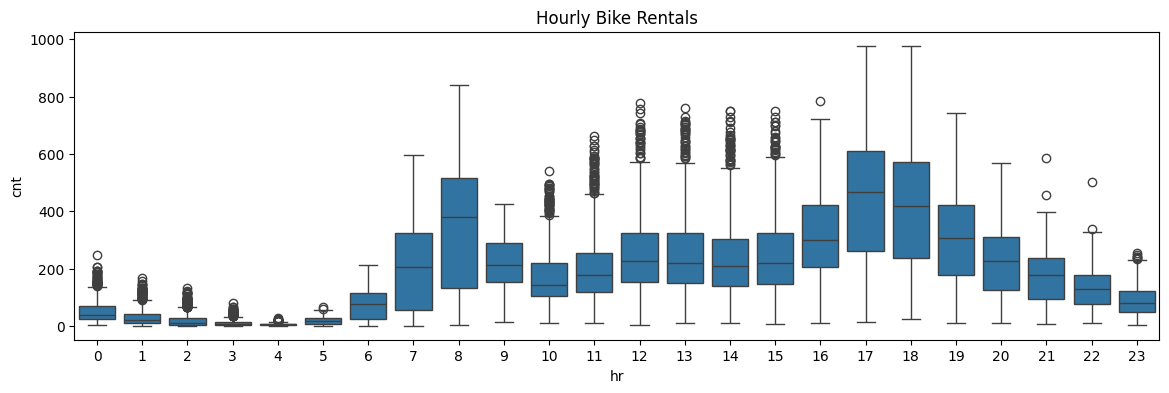

In [4]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="hr", y="cnt")
plt.title("Hourly Bike Rentals")
plt.show()

ÊØèÊòüÊúüÂπæÁßüÂÄüÈáèÂàÜÂ∏É

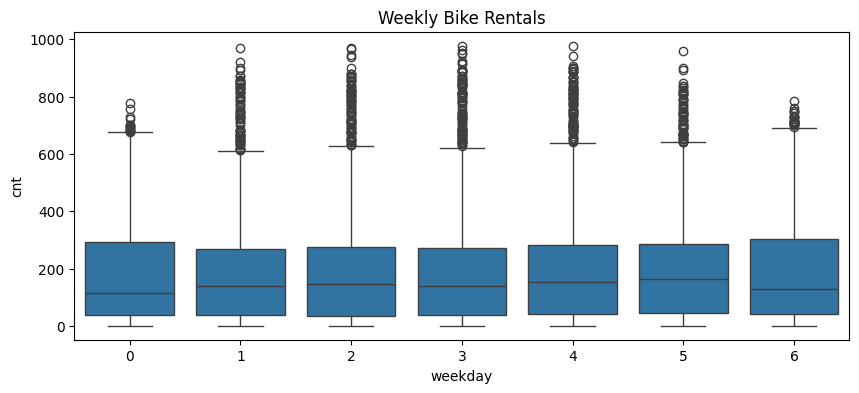

In [5]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="weekday", y="cnt")
plt.title("Weekly Bike Rentals")
plt.show()

ÊØèÊúàÁßüÂÄüÈáèÂàÜÂ∏É

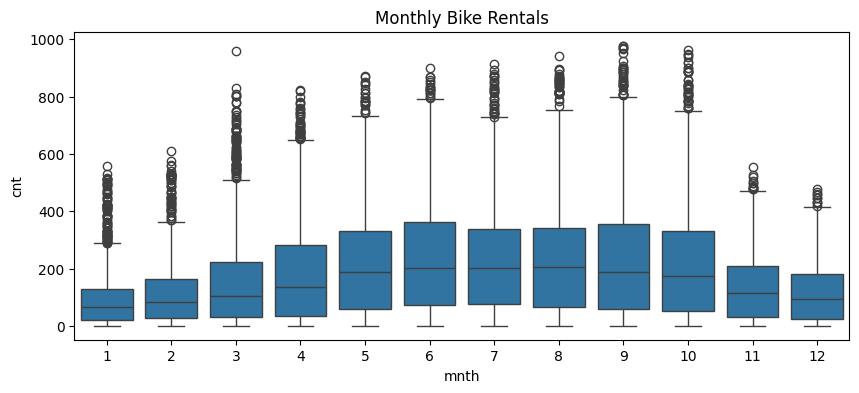

In [6]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="mnth", y="cnt")
plt.title("Monthly Bike Rentals")
plt.show()

È°ûÂà•Ê¨Ñ‰ΩçËàá cnt ÁöÑÈóú‰øÇ

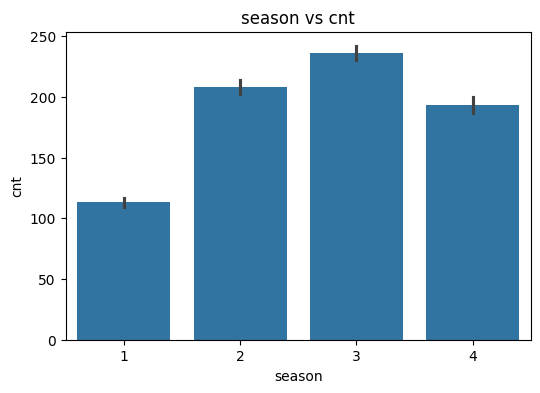

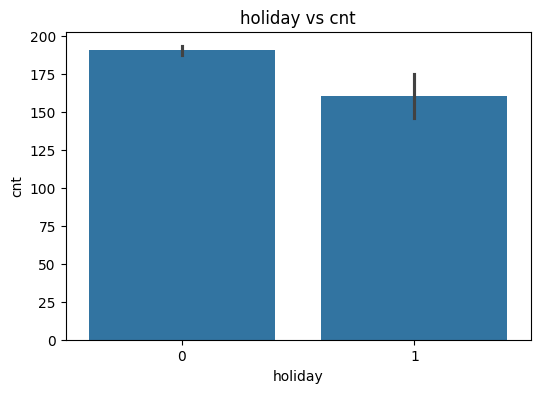

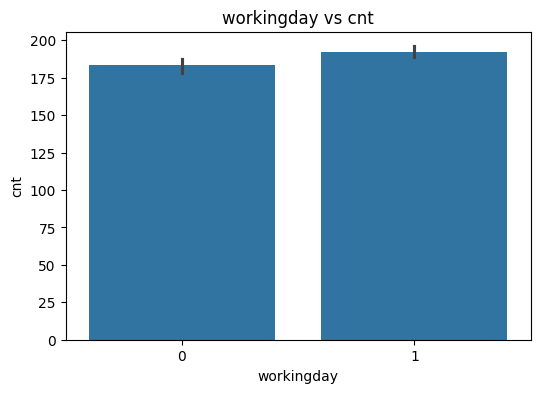

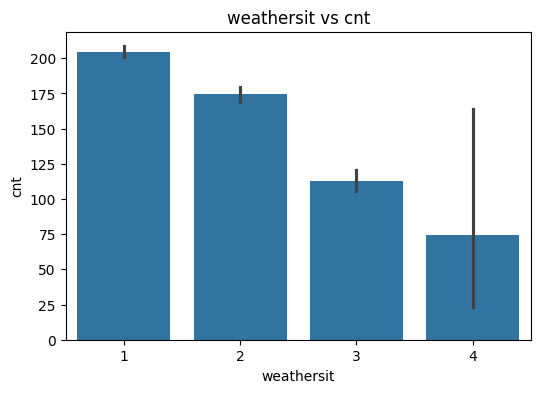

In [7]:
categorical_cols = ["season", "holiday", "workingday", "weathersit"]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x=col, y="cnt")
    plt.title(f"{col} vs cnt")
    plt.show()

Êï∏ÂÄºÁâπÂæµËàá cnt ÁöÑÁõ∏ÈóúÊÄß

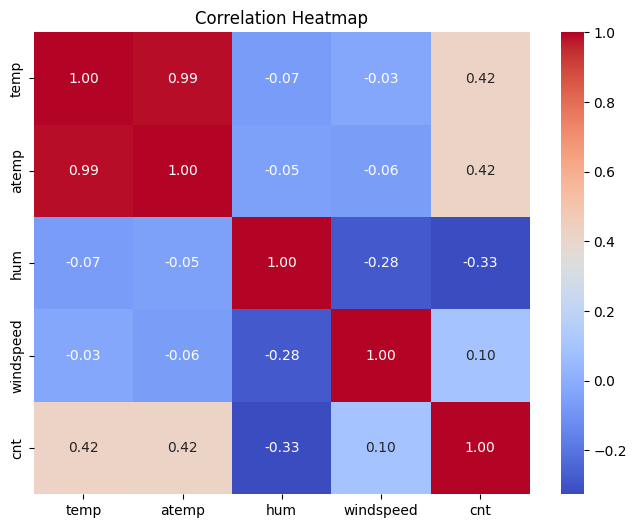

In [8]:
numeric_features = ["temp", "atemp", "hum", "windspeed", "cnt"]
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Step 2ÔºöÁâπÂæµÂ∑•Á®ãËàáË≥áÊñôÂâçËôïÁêÜ

In [3]:
# === ÂéüÂßãË≥áÊñôËÆÄÂèñ ===
df = pd.read_csv("train.csv", parse_dates=["dteday"])
df['date'] = df['dteday']

# === Âä†ÂÖ•ÈÄ±ÊúüÊÄßËàá‰∫§‰∫íÁâπÂæµ ===
df['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
df['hr_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
df['mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
df['mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)

df['hr_x_weekday'] = df['hr'] * df['weekday']
df['hr_x_workingday'] = df['hr'] * df['workingday']
df['temp_x_hum'] = df['temp'] * df['hum']
df['atemp_x_wind'] = df['atemp'] * df['windspeed']

# === ÁâπÂæµÈÅ∏Êìá ===
selected_features = [
    'season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit',
    'temp', 'atemp', 'hum', 'windspeed',
    'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
    'hr_x_weekday', 'hr_x_workingday', 'temp_x_hum', 'atemp_x_wind'
]

categorical_features = ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'atemp', 'hum', 'windspeed',
                      'hr_x_weekday', 'hr_x_workingday', 'temp_x_hum', 'atemp_x_wind']

df_encoded = pd.get_dummies(df[selected_features], columns=categorical_features, drop_first=False)

# === Ê≠£Ë¶èÂåñÊï∏ÂÄºÊ¨Ñ‰Ωç ===
scaler = MinMaxScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# === Âä†‰∏äÁõÆÊ®ôËàáÊôÇÈñìÊ¨Ñ‰Ωç ===
df_encoded['cnt'] = df['cnt']
df_encoded['date'] = df['date']

# === ÂÑ≤Â≠òÊ¨Ñ‰ΩçÈ†ÜÂ∫èÔºàÁµ¶Êé®ÁêÜÁî®Ôºâ===
feature_names = df_encoded.drop(columns=["cnt", "date"]).columns.tolist()
np.save("feature_names.npy", feature_names)

# === ÂÑ≤Â≠òË≥áÊñô ===
df_encoded.to_csv("processed_train_33feat.csv", index=False)
print(f"ËôïÁêÜÂæåÁâπÂæµÊï∏Èáè: {df_encoded.shape[1] - 2}")


ËôïÁêÜÂæåÁâπÂæµÊï∏Èáè: 33


# Step 3ÔºöÂª∫Á´ã Sliding Window Ë≥áÊñôÈõÜ

In [4]:
def create_sliding_window_dataset(df, window_size=24, log_transform=True, start_idx=0):
    assert "cnt" in df.columns and "date" in df.columns, "ÈúÄË¶ÅÂåÖÂê´ cnt Ëàá date Ê¨Ñ‰Ωç"
    
    feature_columns = [col for col in df.columns if col not in ["cnt", "date"]]
    features = df[feature_columns].values
    targets = np.log1p(df["cnt"].values) if log_transform else df["cnt"].values
    times = df["date"].values

    X, y, X_time = [], [], []

    for i in range(start_idx + window_size, len(df)):
        X.append(features[i - window_size:i])
        y.append(targets[i])
        X_time.append(times[i])

    X = np.array(X)
    y = np.array(y)
    X_time = np.array(X_time)

    print(f"Total samples: {len(X)}, Feature dim: {X.shape[-1]}, Window size: {window_size}")
    return X, y, X_time, feature_columns

# Step 4ÔºöLSTM Ê®°ÂûãÂª∫ÊßãËàáË®ìÁ∑¥ÊµÅÁ®ã

Ë≥áÊñôÂàÜÂâ≤

In [5]:
# ËÆÄÂÖ•Ë≥áÊñô
df_processed = pd.read_csv("processed_train_33feat.csv", parse_dates=["date"])

# Âª∫Á´ãË≥áÊñôÈõÜ
X, y, X_time, feature_names = create_sliding_window_dataset(df_processed, window_size=24, log_transform=True)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Ë®ìÁ∑¥ / È©óË≠âÂàáÂàÜ
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]
X_time_train, X_time_val = X_time[:split_idx], X_time[split_idx:]

# Âç∞Âá∫Ë≥áË®ä
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print(f"Ë®ìÁ∑¥ÊôÇÈñìÁØÑÂúç: {X_time_train[0]} ~ {X_time_train[-1]}")
print(f"È©óË≠âÊôÇÈñìÁØÑÂúç: {X_time_val[0]} ~ {X_time_val[-1]}")


Total samples: 15895, Feature dim: 33, Window size: 24
X_train shape: (12716, 24, 33)
y_train shape: (12716,)
X_val shape: (3179, 24, 33)
y_val shape: (3179,)
Ë®ìÁ∑¥ÊôÇÈñìÁØÑÂúç: 2011-01-02T00:00:00.000000000 ~ 2012-06-20T00:00:00.000000000
È©óË≠âÊôÇÈñìÁØÑÂúç: 2012-06-20T00:00:00.000000000 ~ 2012-10-31T00:00:00.000000000


Dataset È°ûÂà•ÂÆöÁæ©Âíå LSTM Êû∂Êßã

In [6]:
class BikeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.4):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # out: (B, T, H)
        out = out[:, -1, :]           # ÂèñÊúÄÂæå‰∏ÄÂÄãÊôÇÈñìÊ≠•
        out = self.fc(out)            # È†êÊ∏¨‰∏ÄÂÄãÂÄº
        return F.softplus(out)        # ÂèØÊîπÊàê ReLU Êàñ‰∏çÂä†

DataLoader

In [7]:
# 1. Âª∫Á´ã Dataset
train_dataset = BikeDataset(X_train, y_train)
val_dataset = BikeDataset(X_val, y_val)

# 2. Âª∫Á´ã DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

‰ΩøÁî® RMSLE Loss Ë®ìÁ∑¥

In [8]:
def rmsle_loss_log_space(pred_log, target_log):
    return torch.sqrt(torch.mean((pred_log - target_log) ** 2))

In [11]:
# --- ÂàùÂßãÂåñ ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=X.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

EPOCHS = 300
patience = 100
best_val_loss = float('inf')
no_improve_epochs = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1:03d}]", leave=False)
    for xb, yb in train_bar:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = rmsle_loss_log_space(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_train_loss += loss.item() * len(xb)
        train_bar.set_postfix(loss=loss.item())

    # === È©óË≠â ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_val_loss += rmsle_loss_log_space(pred, yb).item() * len(xb)


    # === Âπ≥Âùá loss ===
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # === Ê®°ÂûãÂÑ≤Â≠ò ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print("‚úÖ Best model saved.")
    else:
        no_improve_epochs += 1
        print(f"üîÅ No improvement ({no_improve_epochs}/{patience})")

    # === Êõ¥Êñ∞Â≠∏ÁøíÁéá ===
    scheduler.step(avg_val_loss)

    # === Early stopping ===
    if no_improve_epochs >= patience:
        print("üõë Early stopping triggered.")
        break


Epoch 001 | Train Loss: 2.7945 | Val Loss: 1.5130
‚úÖ Best model saved.


Epoch 002 | Train Loss: 1.3875 | Val Loss: 1.4489
‚úÖ Best model saved.


Epoch 003 | Train Loss: 1.2087 | Val Loss: 0.9015
‚úÖ Best model saved.


Epoch 004 | Train Loss: 0.6957 | Val Loss: 0.6680
‚úÖ Best model saved.


Epoch 005 | Train Loss: 0.6102 | Val Loss: 0.5798
‚úÖ Best model saved.


Epoch 006 | Train Loss: 0.5670 | Val Loss: 0.5371
‚úÖ Best model saved.


Epoch 007 | Train Loss: 0.5416 | Val Loss: 0.5107
‚úÖ Best model saved.


Epoch 008 | Train Loss: 0.5236 | Val Loss: 0.4985
‚úÖ Best model saved.


Epoch 009 | Train Loss: 0.5036 | Val Loss: 0.4298
‚úÖ Best model saved.


Epoch 010 | Train Loss: 0.4853 | Val Loss: 0.4226
‚úÖ Best model saved.


Epoch 011 | Train Loss: 0.4682 | Val Loss: 0.3939
‚úÖ Best model saved.


Epoch 012 | Train Loss: 0.4550 | Val Loss: 0.3771
‚úÖ Best model saved.


Epoch 013 | Train Loss: 0.4445 | Val Loss: 0.3939
üîÅ No improvement (1/100)


Epoch 014 | Train Loss: 0.4399 | Val Loss: 0.3649
‚úÖ Best model saved.


Epoch 015 | Train Loss: 0.4317 | Val Loss: 0.3586
‚úÖ Best model saved.


Epoch 016 | Train Loss: 0.4248 | Val Loss: 0.3592
üîÅ No improvement (1/100)


Epoch 017 | Train Loss: 0.4212 | Val Loss: 0.3470
‚úÖ Best model saved.


Epoch 018 | Train Loss: 0.4154 | Val Loss: 0.3471
üîÅ No improvement (1/100)


Epoch 019 | Train Loss: 0.4130 | Val Loss: 0.3382
‚úÖ Best model saved.


Epoch 020 | Train Loss: 0.4105 | Val Loss: 0.3448
üîÅ No improvement (1/100)


Epoch 021 | Train Loss: 0.4058 | Val Loss: 0.3338
‚úÖ Best model saved.


Epoch 022 | Train Loss: 0.4044 | Val Loss: 0.3468
üîÅ No improvement (1/100)


Epoch 023 | Train Loss: 0.4007 | Val Loss: 0.3360
üîÅ No improvement (2/100)


Epoch 024 | Train Loss: 0.3974 | Val Loss: 0.3413
üîÅ No improvement (3/100)


Epoch 025 | Train Loss: 0.3930 | Val Loss: 0.3192
‚úÖ Best model saved.


Epoch 026 | Train Loss: 0.3913 | Val Loss: 0.3267
üîÅ No improvement (1/100)


Epoch 027 | Train Loss: 0.3891 | Val Loss: 0.3191
‚úÖ Best model saved.


Epoch 028 | Train Loss: 0.3848 | Val Loss: 0.3158
‚úÖ Best model saved.


Epoch 029 | Train Loss: 0.3857 | Val Loss: 0.3172
üîÅ No improvement (1/100)


Epoch 030 | Train Loss: 0.3813 | Val Loss: 0.3136
‚úÖ Best model saved.


Epoch 031 | Train Loss: 0.3835 | Val Loss: 0.3077
‚úÖ Best model saved.


Epoch 032 | Train Loss: 0.3801 | Val Loss: 0.3170
üîÅ No improvement (1/100)


Epoch 033 | Train Loss: 0.3784 | Val Loss: 0.3162
üîÅ No improvement (2/100)


Epoch 034 | Train Loss: 0.3779 | Val Loss: 0.3080
üîÅ No improvement (3/100)


Epoch 035 | Train Loss: 0.3753 | Val Loss: 0.3121
üîÅ No improvement (4/100)


Epoch 036 | Train Loss: 0.3733 | Val Loss: 0.3071
‚úÖ Best model saved.


Epoch 037 | Train Loss: 0.3704 | Val Loss: 0.3055
‚úÖ Best model saved.


Epoch 038 | Train Loss: 0.3707 | Val Loss: 0.3028
‚úÖ Best model saved.


Epoch 039 | Train Loss: 0.3690 | Val Loss: 0.3041
üîÅ No improvement (1/100)


Epoch 040 | Train Loss: 0.3664 | Val Loss: 0.3124
üîÅ No improvement (2/100)


Epoch 041 | Train Loss: 0.3654 | Val Loss: 0.3018
‚úÖ Best model saved.


Epoch 042 | Train Loss: 0.3619 | Val Loss: 0.2992
‚úÖ Best model saved.


Epoch 043 | Train Loss: 0.3643 | Val Loss: 0.3005
üîÅ No improvement (1/100)


Epoch 044 | Train Loss: 0.3645 | Val Loss: 0.3017
üîÅ No improvement (2/100)


Epoch 045 | Train Loss: 0.3591 | Val Loss: 0.3034
üîÅ No improvement (3/100)


Epoch 046 | Train Loss: 0.3576 | Val Loss: 0.3006
üîÅ No improvement (4/100)


Epoch 047 | Train Loss: 0.3580 | Val Loss: 0.3122
üîÅ No improvement (5/100)


Epoch 048 | Train Loss: 0.3568 | Val Loss: 0.2945
‚úÖ Best model saved.


Epoch 049 | Train Loss: 0.3536 | Val Loss: 0.3022
üîÅ No improvement (1/100)


Epoch 050 | Train Loss: 0.3558 | Val Loss: 0.3075
üîÅ No improvement (2/100)


Epoch 051 | Train Loss: 0.3544 | Val Loss: 0.3036
üîÅ No improvement (3/100)


Epoch 052 | Train Loss: 0.3521 | Val Loss: 0.2953
üîÅ No improvement (4/100)


Epoch 053 | Train Loss: 0.3508 | Val Loss: 0.2974
üîÅ No improvement (5/100)


Epoch 054 | Train Loss: 0.3511 | Val Loss: 0.2949
üîÅ No improvement (6/100)


Epoch 055 | Train Loss: 0.3485 | Val Loss: 0.3007
üîÅ No improvement (7/100)


Epoch 056 | Train Loss: 0.3496 | Val Loss: 0.2971
üîÅ No improvement (8/100)


Epoch 057 | Train Loss: 0.3464 | Val Loss: 0.2900
‚úÖ Best model saved.


Epoch 058 | Train Loss: 0.3473 | Val Loss: 0.3057
üîÅ No improvement (1/100)


Epoch 059 | Train Loss: 0.3458 | Val Loss: 0.3025
üîÅ No improvement (2/100)


Epoch 060 | Train Loss: 0.3445 | Val Loss: 0.3006
üîÅ No improvement (3/100)


Epoch 061 | Train Loss: 0.3438 | Val Loss: 0.2883
‚úÖ Best model saved.


Epoch 062 | Train Loss: 0.3427 | Val Loss: 0.2984
üîÅ No improvement (1/100)


Epoch 063 | Train Loss: 0.3416 | Val Loss: 0.2971
üîÅ No improvement (2/100)


Epoch 064 | Train Loss: 0.3422 | Val Loss: 0.3013
üîÅ No improvement (3/100)


Epoch 065 | Train Loss: 0.3401 | Val Loss: 0.2944
üîÅ No improvement (4/100)


Epoch 066 | Train Loss: 0.3393 | Val Loss: 0.2984
üîÅ No improvement (5/100)


Epoch 067 | Train Loss: 0.3377 | Val Loss: 0.3113
üîÅ No improvement (6/100)


Epoch 068 | Train Loss: 0.3385 | Val Loss: 0.3080
üîÅ No improvement (7/100)


Epoch 069 | Train Loss: 0.3354 | Val Loss: 0.2913
üîÅ No improvement (8/100)


Epoch 070 | Train Loss: 0.3379 | Val Loss: 0.2995
üîÅ No improvement (9/100)


Epoch 071 | Train Loss: 0.3352 | Val Loss: 0.3068
üîÅ No improvement (10/100)


Epoch 072 | Train Loss: 0.3348 | Val Loss: 0.2911
üîÅ No improvement (11/100)


Epoch 073 | Train Loss: 0.3331 | Val Loss: 0.3117
üîÅ No improvement (12/100)


Epoch 074 | Train Loss: 0.3324 | Val Loss: 0.3024
üîÅ No improvement (13/100)


Epoch 075 | Train Loss: 0.3329 | Val Loss: 0.3014
üîÅ No improvement (14/100)


Epoch 076 | Train Loss: 0.3295 | Val Loss: 0.2960
üîÅ No improvement (15/100)


Epoch 077 | Train Loss: 0.3302 | Val Loss: 0.2917
üîÅ No improvement (16/100)


Epoch 078 | Train Loss: 0.3292 | Val Loss: 0.2974
üîÅ No improvement (17/100)


Epoch 079 | Train Loss: 0.3296 | Val Loss: 0.3107
üîÅ No improvement (18/100)


Epoch 080 | Train Loss: 0.3287 | Val Loss: 0.3067
üîÅ No improvement (19/100)


Epoch 081 | Train Loss: 0.3282 | Val Loss: 0.3013
üîÅ No improvement (20/100)


Epoch 082 | Train Loss: 0.3268 | Val Loss: 0.3088
üîÅ No improvement (21/100)


Epoch 083 | Train Loss: 0.3226 | Val Loss: 0.2950
üîÅ No improvement (22/100)


Epoch 084 | Train Loss: 0.3242 | Val Loss: 0.2970
üîÅ No improvement (23/100)


Epoch 085 | Train Loss: 0.3236 | Val Loss: 0.3032
üîÅ No improvement (24/100)


Epoch 086 | Train Loss: 0.3230 | Val Loss: 0.3054
üîÅ No improvement (25/100)


Epoch 087 | Train Loss: 0.3246 | Val Loss: 0.2981
üîÅ No improvement (26/100)


Epoch 088 | Train Loss: 0.3222 | Val Loss: 0.2957
üîÅ No improvement (27/100)


Epoch 089 | Train Loss: 0.3224 | Val Loss: 0.2961
üîÅ No improvement (28/100)


Epoch 090 | Train Loss: 0.3172 | Val Loss: 0.3008
üîÅ No improvement (29/100)


Epoch 091 | Train Loss: 0.3206 | Val Loss: 0.3037
üîÅ No improvement (30/100)


Epoch 092 | Train Loss: 0.3223 | Val Loss: 0.3019
üîÅ No improvement (31/100)


Epoch 093 | Train Loss: 0.3206 | Val Loss: 0.2991
üîÅ No improvement (32/100)


Epoch 094 | Train Loss: 0.3210 | Val Loss: 0.3028
üîÅ No improvement (33/100)


Epoch 095 | Train Loss: 0.3200 | Val Loss: 0.2957
üîÅ No improvement (34/100)


Epoch 096 | Train Loss: 0.3197 | Val Loss: 0.3018
üîÅ No improvement (35/100)


Epoch 097 | Train Loss: 0.3206 | Val Loss: 0.3091
üîÅ No improvement (36/100)


Epoch 098 | Train Loss: 0.3188 | Val Loss: 0.3032
üîÅ No improvement (37/100)


Epoch 099 | Train Loss: 0.3203 | Val Loss: 0.2995
üîÅ No improvement (38/100)


Epoch 100 | Train Loss: 0.3179 | Val Loss: 0.3020
üîÅ No improvement (39/100)


Epoch 101 | Train Loss: 0.3175 | Val Loss: 0.3026
üîÅ No improvement (40/100)


Epoch 102 | Train Loss: 0.3173 | Val Loss: 0.2911
üîÅ No improvement (41/100)


Epoch 103 | Train Loss: 0.3200 | Val Loss: 0.3052
üîÅ No improvement (42/100)


Epoch 104 | Train Loss: 0.3156 | Val Loss: 0.3016
üîÅ No improvement (43/100)


Epoch 105 | Train Loss: 0.3162 | Val Loss: 0.2990
üîÅ No improvement (44/100)


Epoch 106 | Train Loss: 0.3157 | Val Loss: 0.3028
üîÅ No improvement (45/100)


Epoch 107 | Train Loss: 0.3121 | Val Loss: 0.3071
üîÅ No improvement (46/100)


Epoch 108 | Train Loss: 0.3142 | Val Loss: 0.3003
üîÅ No improvement (47/100)


Epoch 109 | Train Loss: 0.3134 | Val Loss: 0.3017
üîÅ No improvement (48/100)


Epoch 110 | Train Loss: 0.3151 | Val Loss: 0.3030
üîÅ No improvement (49/100)


Epoch 111 | Train Loss: 0.3115 | Val Loss: 0.2977
üîÅ No improvement (50/100)


Epoch 112 | Train Loss: 0.3159 | Val Loss: 0.2962
üîÅ No improvement (51/100)


Epoch 113 | Train Loss: 0.3131 | Val Loss: 0.3021
üîÅ No improvement (52/100)


Epoch 114 | Train Loss: 0.3131 | Val Loss: 0.3053
üîÅ No improvement (53/100)


Epoch 115 | Train Loss: 0.3138 | Val Loss: 0.2989
üîÅ No improvement (54/100)


Epoch 116 | Train Loss: 0.3128 | Val Loss: 0.3008
üîÅ No improvement (55/100)


Epoch 117 | Train Loss: 0.3141 | Val Loss: 0.3028
üîÅ No improvement (56/100)


Epoch 118 | Train Loss: 0.3128 | Val Loss: 0.3081
üîÅ No improvement (57/100)


Epoch 119 | Train Loss: 0.3133 | Val Loss: 0.3036
üîÅ No improvement (58/100)


Epoch 120 | Train Loss: 0.3140 | Val Loss: 0.3028
üîÅ No improvement (59/100)


Epoch 121 | Train Loss: 0.3111 | Val Loss: 0.3076
üîÅ No improvement (60/100)


Epoch 122 | Train Loss: 0.3119 | Val Loss: 0.3022
üîÅ No improvement (61/100)


Epoch 123 | Train Loss: 0.3092 | Val Loss: 0.3059
üîÅ No improvement (62/100)


Epoch 124 | Train Loss: 0.3124 | Val Loss: 0.3030
üîÅ No improvement (63/100)


Epoch 125 | Train Loss: 0.3132 | Val Loss: 0.3010
üîÅ No improvement (64/100)


Epoch 126 | Train Loss: 0.3101 | Val Loss: 0.3011
üîÅ No improvement (65/100)


Epoch 127 | Train Loss: 0.3118 | Val Loss: 0.3016
üîÅ No improvement (66/100)


Epoch 128 | Train Loss: 0.3102 | Val Loss: 0.3038
üîÅ No improvement (67/100)


Epoch 129 | Train Loss: 0.3104 | Val Loss: 0.3018
üîÅ No improvement (68/100)


Epoch 130 | Train Loss: 0.3091 | Val Loss: 0.3055
üîÅ No improvement (69/100)


Epoch 131 | Train Loss: 0.3106 | Val Loss: 0.3026
üîÅ No improvement (70/100)


Epoch 132 | Train Loss: 0.3096 | Val Loss: 0.3002
üîÅ No improvement (71/100)


Epoch 133 | Train Loss: 0.3102 | Val Loss: 0.3055
üîÅ No improvement (72/100)


Epoch 134 | Train Loss: 0.3087 | Val Loss: 0.3029
üîÅ No improvement (73/100)


Epoch 135 | Train Loss: 0.3087 | Val Loss: 0.3028
üîÅ No improvement (74/100)


Epoch 136 | Train Loss: 0.3104 | Val Loss: 0.3024
üîÅ No improvement (75/100)


Epoch 137 | Train Loss: 0.3094 | Val Loss: 0.3044
üîÅ No improvement (76/100)


Epoch 138 | Train Loss: 0.3088 | Val Loss: 0.3054
üîÅ No improvement (77/100)


Epoch 139 | Train Loss: 0.3093 | Val Loss: 0.3001
üîÅ No improvement (78/100)


Epoch 140 | Train Loss: 0.3095 | Val Loss: 0.3032
üîÅ No improvement (79/100)


Epoch 141 | Train Loss: 0.3093 | Val Loss: 0.3009
üîÅ No improvement (80/100)


Epoch 142 | Train Loss: 0.3104 | Val Loss: 0.3015
üîÅ No improvement (81/100)


Epoch 143 | Train Loss: 0.3097 | Val Loss: 0.3010
üîÅ No improvement (82/100)


Epoch 144 | Train Loss: 0.3108 | Val Loss: 0.3012
üîÅ No improvement (83/100)


Epoch 145 | Train Loss: 0.3066 | Val Loss: 0.3012
üîÅ No improvement (84/100)


Epoch 146 | Train Loss: 0.3093 | Val Loss: 0.3026
üîÅ No improvement (85/100)


Epoch 147 | Train Loss: 0.3078 | Val Loss: 0.3045
üîÅ No improvement (86/100)


Epoch 148 | Train Loss: 0.3081 | Val Loss: 0.3042
üîÅ No improvement (87/100)


Epoch 149 | Train Loss: 0.3059 | Val Loss: 0.3020
üîÅ No improvement (88/100)


Epoch 150 | Train Loss: 0.3071 | Val Loss: 0.3040
üîÅ No improvement (89/100)


Epoch 151 | Train Loss: 0.3104 | Val Loss: 0.3046
üîÅ No improvement (90/100)


Epoch 152 | Train Loss: 0.3078 | Val Loss: 0.3027
üîÅ No improvement (91/100)


Epoch 153 | Train Loss: 0.3081 | Val Loss: 0.3043
üîÅ No improvement (92/100)


Epoch 154 | Train Loss: 0.3084 | Val Loss: 0.3021
üîÅ No improvement (93/100)


Epoch 155 | Train Loss: 0.3077 | Val Loss: 0.3046
üîÅ No improvement (94/100)


Epoch 156 | Train Loss: 0.3092 | Val Loss: 0.3052
üîÅ No improvement (95/100)


Epoch 157 | Train Loss: 0.3066 | Val Loss: 0.3041
üîÅ No improvement (96/100)


Epoch 158 | Train Loss: 0.3059 | Val Loss: 0.3021
üîÅ No improvement (97/100)


Epoch 159 | Train Loss: 0.3082 | Val Loss: 0.3033
üîÅ No improvement (98/100)


Epoch 160 | Train Loss: 0.3076 | Val Loss: 0.3054
üîÅ No improvement (99/100)


Epoch 161 | Train Loss: 0.3075 | Val Loss: 0.3067
üîÅ No improvement (100/100)
üõë Early stopping triggered.


Loss ÊäòÁ∑öÂúñ

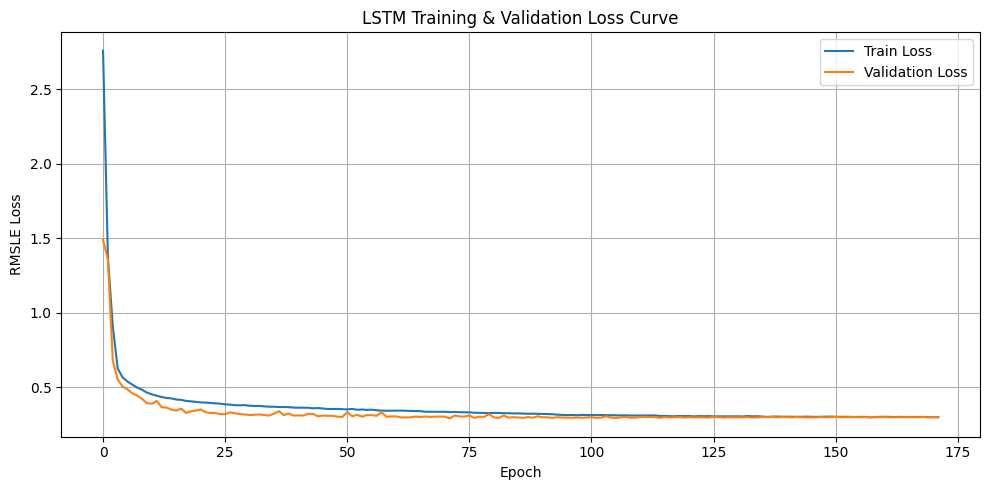

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSLE Loss")
plt.title("LSTM Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ÊôÇÈñìÂ∫èÂàóÁ∑öÂúñÔºàÈ†êÊ∏¨Êõ≤Á∑ö vs ÁúüÂØ¶Êõ≤Á∑öÔºâ

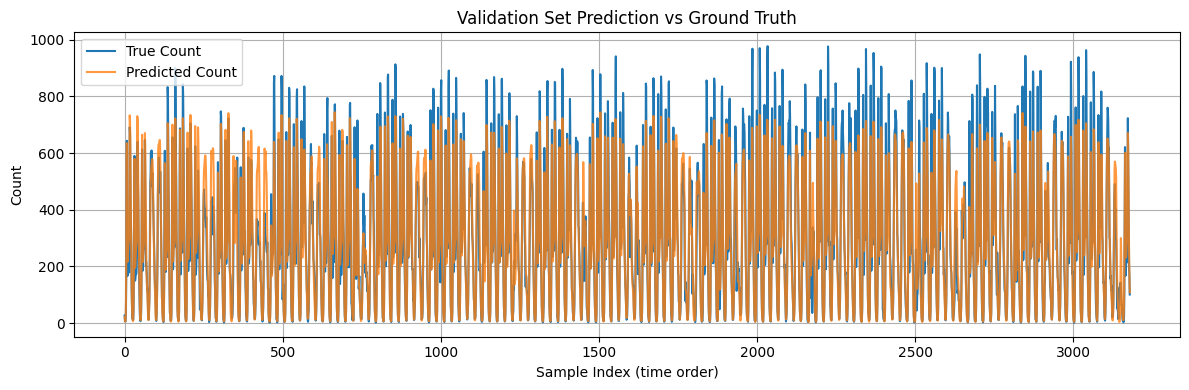

In [18]:
true_series = []
pred_series = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        true_series.extend(torch.expm1(yb).cpu().numpy())
        pred_series.extend(torch.expm1(pred).cpu().numpy())

plt.figure(figsize=(12, 4))
plt.plot(true_series, label="True Count", linewidth=1.5)
plt.plot(pred_series, label="Predicted Count", linewidth=1.5, alpha=0.8)
plt.xlabel("Sample Index (time order)")
plt.ylabel("Count")
plt.title("Validation Set Prediction vs Ground Truth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


È†êÊ∏¨ÂÄº vs ÁúüÂØ¶ÂÄºÔºàÊï£ÈªûÂúñÔºâ

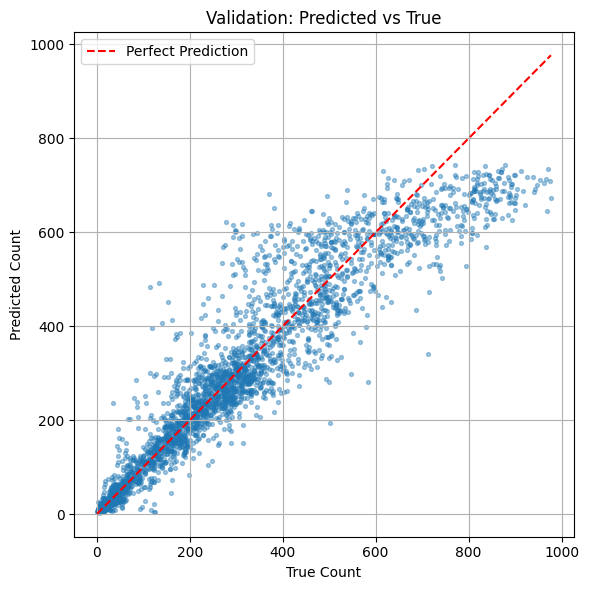

In [19]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        y_true.extend(torch.expm1(yb).cpu().numpy())  # ÈÇÑÂéü log1p
        y_pred.extend(torch.expm1(pred).cpu().numpy())

# === Áï´Êï£ÈªûÂúñ ===
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4, s=8)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction')
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.title("Validation: Predicted vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5 ÁõÆÊ®ô

In [10]:
# === ÊôÇÈñìÈÄ±ÊúüÁâπÂæµÂáΩÊï∏ ===
def add_time_features(df):
    df["hr_sin"] = np.sin(2 * np.pi * df["hr"] / 24)
    df["hr_cos"] = np.cos(2 * np.pi * df["hr"] / 24)
    df["mnth_sin"] = np.sin(2 * np.pi * df["mnth"] / 12)
    df["mnth_cos"] = np.cos(2 * np.pi * df["mnth"] / 12)
    return df

# === Êñ∞Â¢û‰∫§‰∫íÁâπÂæµÂáΩÊï∏ ===
def add_interaction_features(df):
    df["hr_x_weekday"] = df["hr"] * df["weekday"]
    df["hr_x_workingday"] = df["hr"] * df["workingday"]
    df["temp_x_hum"] = df["temp"] * df["hum"]
    df["atemp_x_wind"] = df["atemp"] * df["windspeed"]
    return df

# === ÁâπÂæµÊ¨Ñ‰ΩçË®≠ÂÆö ===
basic_features = [
    'season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit',
    'temp', 'atemp', 'hum', 'windspeed'
]
time_features = ['hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos']
interaction_features = ['hr_x_weekday', 'hr_x_workingday', 'temp_x_hum', 'atemp_x_wind']
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed', 'hr_x_weekday', 'hr_x_workingday',
                  'temp_x_hum', 'atemp_x_wind']
categorical_cols = ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']

# === ËôïÁêÜ train Ë≥áÊñôÂª∫Á´ã scaler + Ê¨Ñ‰ΩçÈ†ÜÂ∫èÂü∫Ê∫ñ ===
df_train = pd.read_csv("train.csv", parse_dates=["dteday"])
df_train["date"] = df_train["dteday"]
df_train = add_time_features(df_train)
df_train = add_interaction_features(df_train)

df_train_encoded = pd.get_dummies(df_train[basic_features + time_features + interaction_features],
                                  columns=categorical_cols, drop_first=False)

scaler = MinMaxScaler()
df_train_encoded[numerical_cols] = scaler.fit_transform(df_train_encoded[numerical_cols])

# === ËôïÁêÜ test Ë≥áÊñô ===
df_test = pd.read_csv("test.csv", parse_dates=["dteday"])
df_test["cnt"] = 0  # ‰Ωî‰Ωç
df_test["date"] = df_test["dteday"]
df_test = add_time_features(df_test)
df_test = add_interaction_features(df_test)

df_test_encoded = pd.get_dummies(df_test[basic_features + time_features + interaction_features],
                                 columns=categorical_cols, drop_first=False)
df_test_encoded[numerical_cols] = scaler.transform(df_test_encoded[numerical_cols])

# === Ê¨Ñ‰ΩçÂ∞çÈΩäÔºàÈÅøÂÖçÁº∫Ê¨Ñ„ÄÅÈ†ÜÂ∫èÈåØË™§Ôºâ===
for col in df_train_encoded.columns:
    if col not in df_test_encoded.columns:
        df_test_encoded[col] = 0.0
df_test_encoded = df_test_encoded[df_train_encoded.columns]

# === Âêà‰ΩµË≥áÊñôÔºàtrain + testÔºâÂª∫Á´ãÊªëÁ™óÂ∫èÂàó ===
df_all = pd.concat([df_train_encoded, df_test_encoded], ignore_index=True)
X_all = df_all.values.astype(np.float32)

# === ËºâÂÖ•Ë®ìÁ∑¥Â•ΩÁöÑÊ®°Âûã ===
WINDOW = 24
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMRegressor(input_size=X_all.shape[1]).to(DEVICE)
model.load_state_dict(torch.load("best_lstm_model.pt", map_location=DEVICE))
model.eval()

# === ÊªëÂãïÁ™óÂè£ÈÄêÊ≠•È†êÊ∏¨ ===
y_preds = []
with torch.no_grad():
    for i in range(len(df_train_encoded), len(df_all)):
        x_window = X_all[i - WINDOW:i]
        x_input = torch.tensor(x_window[np.newaxis, :, :], dtype=torch.float32).to(DEVICE)
        pred_log = model(x_input).item()
        pred_cnt = np.expm1(pred_log)  # ÈÇÑÂéü log1p
        y_preds.append(pred_cnt)

# === Áî¢Âá∫ÊØèÊó•Á∏ΩÂíåÈ†êÊ∏¨ ===
df_test["predicted_cnt"] = y_preds
df_test["date"] = df_test["dteday"].dt.date
daily_pred = df_test.groupby("date")["predicted_cnt"].sum().reset_index()

# === ÁîüÊàêÊèê‰∫§Ê™îÊ°à ===
submission = pd.read_csv("sample_submission.csv")
assert len(submission) == len(daily_pred), "submission row count mismatch!"
submission["cnt"] = daily_pred["predicted_cnt"].values
submission.to_csv("submission.csv", index=False)
print("‚úÖ È†êÊ∏¨ÂÆåÊàêÔºåÂ∑≤ÂÑ≤Â≠òÁÇ∫ submission.csv")

‚úÖ È†êÊ∏¨ÂÆåÊàêÔºåÂ∑≤ÂÑ≤Â≠òÁÇ∫ submission.csv


# SHAP ÂàÜÊûê

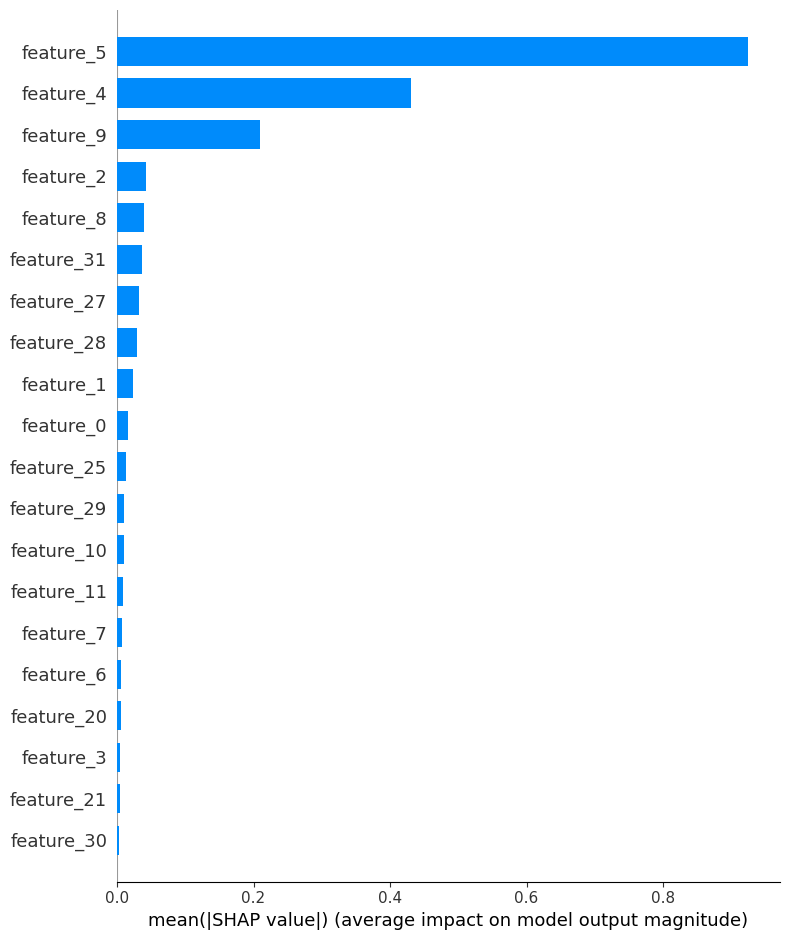

In [20]:
# 1. ÂèñÂá∫ÊØèÁ≠ÜÊ®£Êú¨ÁöÑÊúÄÂæå‰∏ÄÂ∞èÊôÇ‰ΩúÁÇ∫Á∞°ÂåñÁâπÂæµÂêëÈáèÔºàÂè™Áúã t=72Ôºâ
X_flat = X_val[:, -1, :]  

# 2. ËΩâÁÇ∫ numpy arrayÔºåÁ¢∫‰øùÂèØ‰ª•ÂÇ≥ÂÖ• sklearn
X_flat_np = X_flat if isinstance(X_flat, np.ndarray) else X_flat.numpy()
y_val_np = y_val if isinstance(y_val, np.ndarray) else y_val.numpy()

# 3. Âª∫‰∏ÄÂÄãÁ∞°ÂñÆÁöÑÊ®°ÂûãÔºöRandom Forest ‰æÜËøë‰ºº LSTM Ëº∏Âá∫
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_flat_np, y_val_np)

# 4. ‰ΩøÁî® SHAP ÂàÜÊûêÈÄôÂÄã RF Ê®°Âûã
explainer = shap.Explainer(model)
shap_values = explainer(X_flat_np)

# 5. ÁâπÂæµÂêçÁ®±
feature_names = [f'feature_{i}' for i in range(X_flat_np.shape[1])]

# 6. Áï´Âúñ
shap.summary_plot(shap_values.values, X_flat_np, feature_names=feature_names, plot_type="bar")

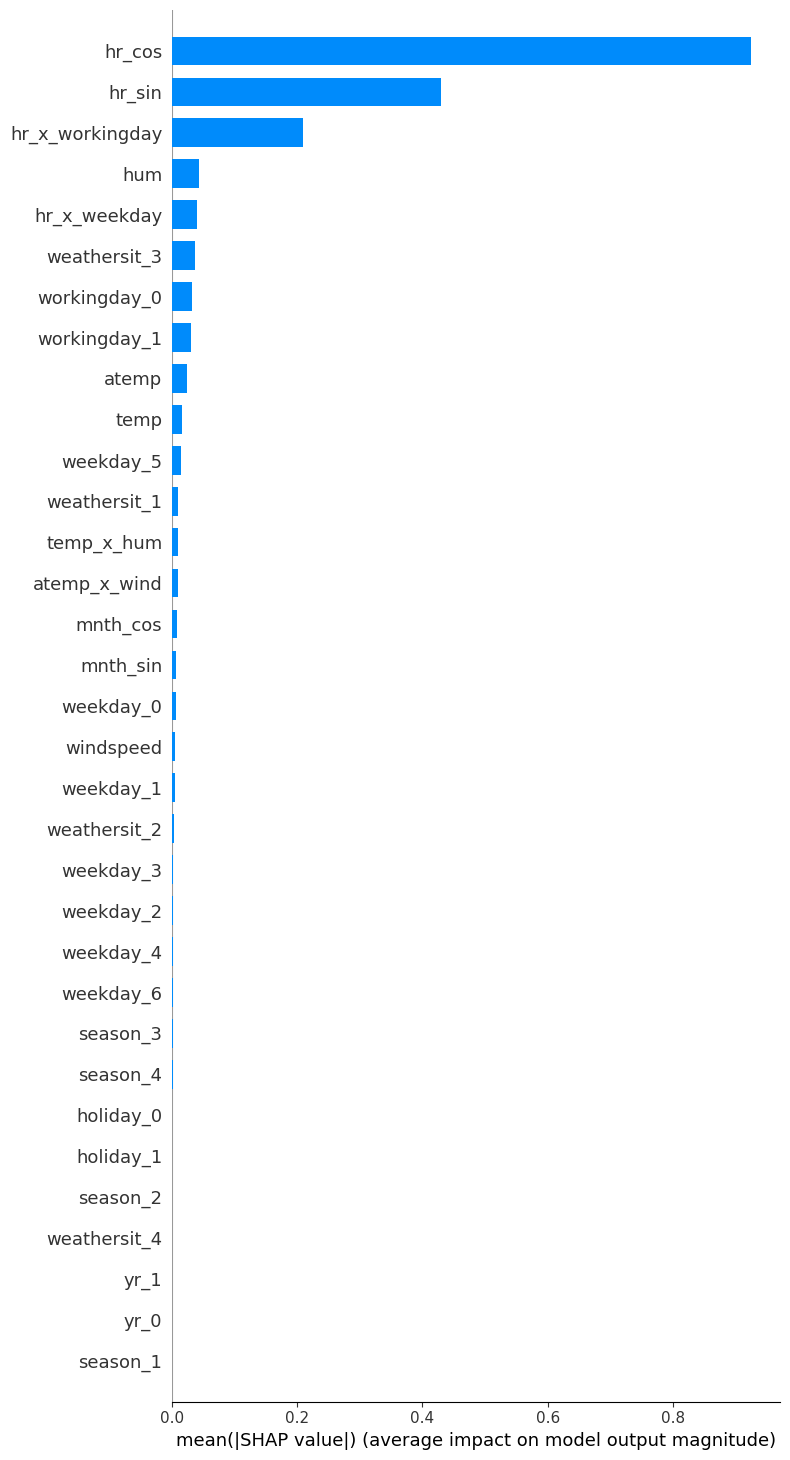

In [21]:
feature_names = np.load("feature_names.npy").tolist()
shap.summary_plot(shap_values.values, X_flat_np, feature_names=feature_names, plot_type="bar", max_display=len(feature_names))